# Fairness and Privacy
This demo demonstrates how to mitigate unfairness through resampling. 

### Step 1: Import Libraries

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

### Step 2: Prepare the Skin Lesion Dataset
Here we use a small split of the ISIC 2019 dataset

In [42]:
# Visualize the data distribution
df = pd.read_csv('/home/siyi/project/course/TAIMI_trustworthy/Data/ISIC2019/label.csv')
df

,image,label,label_code,sex,sex_code
0,ISIC_0034321,NV,0,female,0
1,ISIC_0034322,NV,0,male,1
2,ISIC_0034324,NV,0,male,1
3,ISIC_0034325,NV,0,female,0
4,ISIC_0034328,NV,0,male,1
...,...,...,...,...,...
495,ISIC_0054236,MEL,1,female,0
496,ISIC_0054254,MEL,1,female,0
497,ISIC_0054264,MEL,1,female,0
498,ISIC_0054296,MEL,1,male,1


<AxesSubplot: >

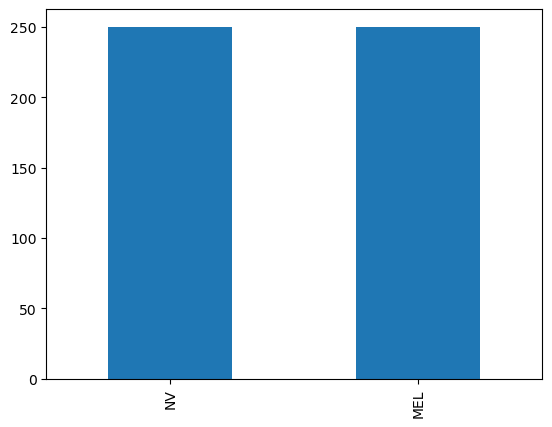

In [43]:
# Label distribution
df['label'].value_counts().plot(kind='bar')

<AxesSubplot: >

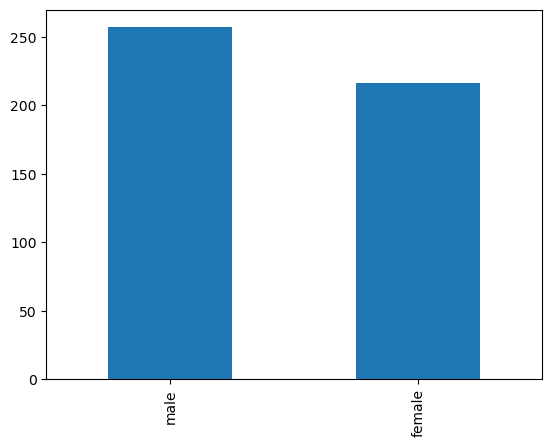

In [44]:
# Sensitive attribute (sex) distribution
df['sex'].value_counts().plot(kind='bar')

In [45]:
root_dir = '/home/siyi/project/course/TAIMI_trustworthy/Data/ISIC2019/images'

class ISICDataset(Dataset):
    def __init__(self, df, root_dir, transform=None, do_train=False):
        self.df = df
        self.root_dir = root_dir
        self.do_train = do_train
        if self.do_train:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])
        print(f'Number of samples: {len(self.df)}')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image']
        img_path = self.root_dir + '/' + img_name + '.jpg'
        image = Image.open(img_path)
        label = row['label_code']
        sensitive_attr = row['sex_code']

        if self.transform:
            image = self.transform(image)

        return image, label, sensitive_attr, img_name

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224), 
    transforms.ToTensor(),
])

# Create train and test datasets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2025)
train_dataset = ISICDataset(train_df, root_dir, transform=train_transform, do_train=True)
test_dataset = ISICDataset(test_df, root_dir)

# # As the dataset is highly imbalanced, we need to use a sampler to balance the classes
# class_sample_count = np.array([len(np.where(train_df['label_code']==t)[0]) for t in np.unique(train_df['label_code'])])
# weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in train_df['label_code']])
# samples_weight = torch.from_numpy(samples_weight)
# sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# Create train and test dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

Number of samples: 400
Number of samples: 100


### Step 3: Define the Model

In [46]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, len(df['label'].unique()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

### Step 4: Train the Model
Define the loss function and optimizer, and train the model on the dataset.

In [28]:
# Training
def training(model, criterion, optimizer, train_loader, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        for images, labels, _, _ in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model


def testing(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        prediction_list = []
        label_list = []
        s_list = []
        for images, labels, s, _ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save predictions, labels, and sensitive attributes
            prediction_list.extend(predicted.cpu().numpy())
            label_list.extend(labels.cpu().numpy())
            s_list.extend(s.cpu().numpy())
        
        print(f'Accuracy: {100 * correct / total:.2f}%')
    return prediction_list, label_list, s_list

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Train the model
model = training(model, criterion, optimizer, train_loader, num_epochs=10)
predictions, labels, sensitive_attrs = testing(model, test_loader)


Epoch [1/15], Loss: 0.1000
Epoch [2/15], Loss: 0.1314
Epoch [3/15], Loss: 0.0514
Epoch [4/15], Loss: 0.4241
Epoch [5/15], Loss: 0.0876
Epoch [6/15], Loss: 0.1981
Epoch [7/15], Loss: 0.0167
Epoch [8/15], Loss: 0.0205
Epoch [9/15], Loss: 0.0386
Epoch [10/15], Loss: 0.0046
Epoch [11/15], Loss: 0.0055
Epoch [12/15], Loss: 0.0468
Epoch [13/15], Loss: 0.0303
Epoch [14/15], Loss: 0.0029
Epoch [15/15], Loss: 0.0143


In [ ]:
#

Accuracy: 90.00%


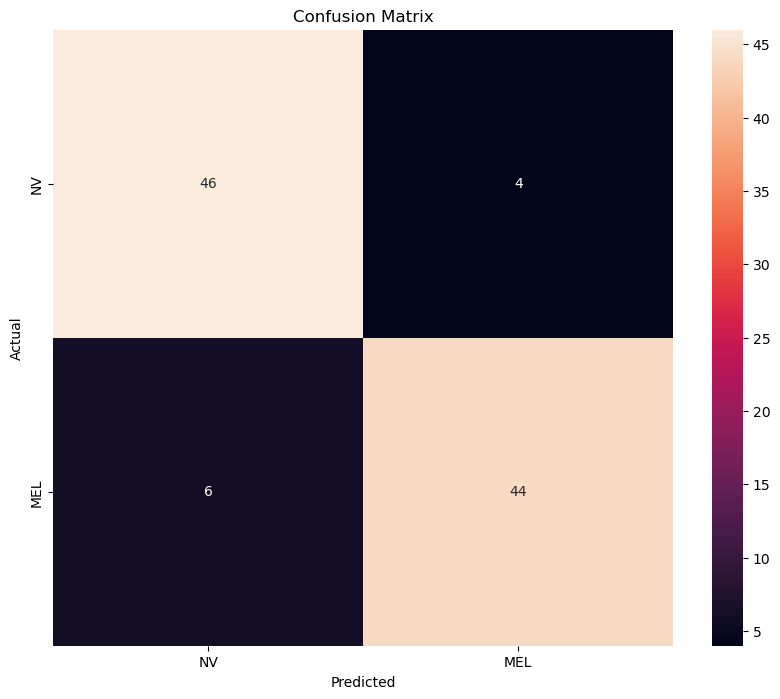

In [49]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=df['label'].unique(), yticklabels=df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
